<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Naive Bayes Classification</p>

*Import Libraries*

In [426]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin # for custom classes
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle

IndentationError: expected an indented block (settings.py, line 199)

*Import data from initial EDA*

In [ ]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Binning numerical features*

In [ ]:
# Bin age to new column and drop original column
df.loc[:,'Age Bin'] = pd.cut(df.loc[:,'Age'], 
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, float('inf')], 
labels=['0-4', '5-9', '10-15', '10-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '>100']).astype("object")
df = df.drop("Age", axis=1)
# check new values in consolidated column
settings.examine_values(df).loc["Age Bin",:]

Unique Values    [25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59]
Name: Age Bin, dtype: object

In [ ]:
# Bin sleep duration to new column and drop original column
df.loc[:,'Sleep Duration Bin'] = pd.cut(df.loc[:,'Sleep Duration'], 
[0, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, float('inf')], 
labels=['<4', '4.0-4.4', '4.5-4.9', '5.0-5.4', '5.5-5.9', '6.0-6.4', '6.5-6.9', '7.0-7.4', '7.5-7.9', '8.0-8.4', '8.5-8.9', '9.0-9.4', '9.5-9.9', '>10']).astype("object")
df = df.drop("Sleep Duration", axis=1)
# check new values in consolidated column
settings.examine_values(df).loc["Sleep Duration Bin",:]

Unique Values    [6.0-6.4, 5.5-5.9, 7.5-7.9, 7.0-7.4, 6.5-6.9, 8.0-8.4]
Name: Sleep Duration Bin, dtype: object

In [ ]:
# Bin physical activity level to new column and drop original column
df.loc[:,'Physical Activity Level Bin'] = pd.cut(df.loc[:,'Physical Activity Level'], 
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')], 
labels=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '>100']).astype("object")
df = df.drop("Physical Activity Level", axis=1)
# check new values in consolidated column
settings.examine_values(df).loc["Physical Activity Level Bin",:]

Unique Values    [40-49, 50-59, 20-29, 30-39, 70-79, 60-69, 80-89]
Name: Physical Activity Level Bin, dtype: object

In [ ]:
# Bin heart rate to new column and drop original column
df.loc[:,'Heart Rate Bin'] = pd.cut(df.loc[:,'Heart Rate'], 
[0, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, float('inf')], 
labels=['<40', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '>100']).astype("object")
df = df.drop("Heart Rate", axis=1)
# check new values in consolidated column
settings.examine_values(df).loc["Heart Rate Bin",:]

Unique Values    [75-79, 70-74, 80-84, 65-69, 60-64, 85-89]
Name: Heart Rate Bin, dtype: object

In [ ]:
# Bin daily steps to new column and drop original column
df.loc[:,'Daily Steps Bin'] = pd.cut(df.loc[:,'Daily Steps'], 
[0, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 100000, float('inf')], 
labels=['<3000', '3000-3499', '3500-3999', '4000-4499', '4500-4999', '5000-5499', '5500-5999', '6000-6499', '6500-6999', '7000-7499', '7500-7999', '8000-8499', '8500-8999', '9000-9499', '9500-9999', '>100']).astype("object")
df = df.drop("Daily Steps", axis=1)
# check new values in consolidated column
settings.examine_values(df).loc["Daily Steps Bin",:]

Unique Values    [4000-4499, 9500-9999, <3000, 3000-3499, 7500-7999, 3500-3999, 6500-6999, 4500-4999, 5000-5499, 5500-5999, 7000-7499, 6000-6499]
Name: Daily Steps Bin, dtype: object

*Split data and prepare labels*

In [458]:
ALL_FEATURES = ['Gender', 'Occupation', 'Stress Level', 'BMI Category', 'Blood Pressure Category', 'Age Bin',
       'Sleep Duration Bin', 'Quality of Sleep', 'Physical Activity Level Bin', 'Heart Rate Bin', 'Daily Steps Bin']

X = df[ALL_FEATURES].astype(str)
y = df[settings.LABEL].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [459]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

In [460]:
# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

In [387]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 230 to 57
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Gender                       187 non-null    object
 1   Occupation                   187 non-null    object
 2   Stress Level                 187 non-null    object
 3   BMI Category                 187 non-null    object
 4   Blood Pressure Category      187 non-null    object
 5   Age Bin                      187 non-null    object
 6   Sleep Duration Bin           187 non-null    object
 7   Quality of Sleep             187 non-null    object
 8   Physical Activity Level Bin  187 non-null    object
 9   Heart Rate Bin               187 non-null    object
 10  Daily Steps Bin              187 non-null    object
dtypes: object(11)
memory usage: 17.5+ KB


*Preprocess steps*

In [461]:
# Create a column transformer for encoding
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown='ignore'), ALL_FEATURES)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# # Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

'train: check for dummy encoded columns and scaled values (mean 0 and std 1)'

(187, 63)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,Stress Level_3,Stress Level_4,Stress Level_5,Stress Level_6,Stress Level_7,Stress Level_8,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age Bin_25-29,Age Bin_30-34,Age Bin_35-39,Age Bin_40-44,Age Bin_45-49,Age Bin_50-54,Age Bin_55-59,Sleep Duration Bin_5.5-5.9,Sleep Duration Bin_6.0-6.4,Sleep Duration Bin_6.5-6.9,Sleep Duration Bin_7.0-7.4,Sleep Duration Bin_7.5-7.9,Sleep Duration Bin_8.0-8.4,Quality of Sleep_4,Quality of Sleep_5,Quality of Sleep_6,Quality of Sleep_7,Quality of Sleep_8,Quality of Sleep_9,Physical Activity Level Bin_20-29,Physical Activity Level Bin_30-39,Physical Activity Level Bin_40-49,Physical Activity Level Bin_50-59,Physical Activity Level Bin_60-69,Physical Activity Level Bin_70-79,Physical Activity Level Bin_80-89,Heart Rate Bin_60-64,Heart Rate Bin_65-69,Heart Rate Bin_70-74,Heart Rate Bin_75-79,Heart Rate Bin_80-84,Daily Steps Bin_3000-3499,Daily Steps Bin_3500-3999,Daily Steps Bin_4000-4499,Daily Steps Bin_4500-4999,Daily Steps Bin_5000-5499,Daily Steps Bin_5500-5999,Daily Steps Bin_6500-6999,Daily Steps Bin_7000-7499,Daily Steps Bin_7500-7999,Daily Steps Bin_9500-9999
mean,0.508021,0.491979,0.080214,0.192513,0.171123,0.128342,0.208556,0.080214,0.117647,0.02139,0.176471,0.181818,0.203209,0.122995,0.133690,0.181818,0.588235,0.411765,0.326203,0.406417,0.176471,0.090909,0.080214,0.160428,0.181818,0.288770,0.080214,0.117647,0.090909,0.101604,0.224599,0.101604,0.192513,0.240642,0.139037,0.005348,0.026738,0.272727,0.229947,0.288770,0.176471,0.171123,0.037433,0.208556,0.192513,0.016043,0.171123,0.203209,0.181818,0.465241,0.294118,0.042781,0.016043,0.010695,0.010695,0.016043,0.176471,0.02139,0.197861,0.165775,0.005348,0.294118,0.101604
std,0.501278,0.501278,0.272353,0.395332,0.377627,0.335368,0.407367,0.272353,0.323055,0.14507,0.382243,0.386730,0.403467,0.329313,0.341232,0.386730,0.493474,0.493474,0.470081,0.492483,0.382243,0.288252,0.272353,0.367988,0.386730,0.454407,0.272353,0.323055,0.288252,0.302938,0.418438,0.302938,0.395332,0.428621,0.346914,0.073127,0.161750,0.446557,0.421928,0.454407,0.382243,0.377627,0.190330,0.407367,0.395332,0.125977,0.377627,0.403467,0.386730,0.500129,0.456868,0.202906,0.125977,0.103139,0.103139,0.125977,0.382243,0.14507,0.399456,0.372877,0.073127,0.456868,0.302938


'test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)'

(187, 63)

,Gender_Female,Gender_Male,Occupation_Accountant,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Nurse,Occupation_Salesperson,Occupation_Teacher,Occupation_Unknown,Stress Level_3,Stress Level_4,Stress Level_5,Stress Level_6,Stress Level_7,Stress Level_8,BMI Category_Normal,BMI Category_Overweight,Blood Pressure Category_Elevated,Blood Pressure Category_High Blood Pressure Stage 1,Blood Pressure Category_High Blood Pressure Stage 2,Blood Pressure Category_Normal,Age Bin_25-29,Age Bin_30-34,Age Bin_35-39,Age Bin_40-44,Age Bin_45-49,Age Bin_50-54,Age Bin_55-59,Sleep Duration Bin_5.5-5.9,Sleep Duration Bin_6.0-6.4,Sleep Duration Bin_6.5-6.9,Sleep Duration Bin_7.0-7.4,Sleep Duration Bin_7.5-7.9,Sleep Duration Bin_8.0-8.4,Quality of Sleep_4,Quality of Sleep_5,Quality of Sleep_6,Quality of Sleep_7,Quality of Sleep_8,Quality of Sleep_9,Physical Activity Level Bin_20-29,Physical Activity Level Bin_30-39,Physical Activity Level Bin_40-49,Physical Activity Level Bin_50-59,Physical Activity Level Bin_60-69,Physical Activity Level Bin_70-79,Physical Activity Level Bin_80-89,Heart Rate Bin_60-64,Heart Rate Bin_65-69,Heart Rate Bin_70-74,Heart Rate Bin_75-79,Heart Rate Bin_80-84,Daily Steps Bin_3000-3499,Daily Steps Bin_3500-3999,Daily Steps Bin_4000-4499,Daily Steps Bin_4500-4999,Daily Steps Bin_5000-5499,Daily Steps Bin_5500-5999,Daily Steps Bin_6500-6999,Daily Steps Bin_7000-7499,Daily Steps Bin_7500-7999,Daily Steps Bin_9500-9999
mean,0.481283,0.518717,0.117647,0.187166,0.165775,0.122995,0.181818,0.090909,0.096257,0.037433,0.203209,0.192513,0.155080,0.122995,0.133690,0.192513,0.566845,0.433155,0.331551,0.326203,0.213904,0.128342,0.090909,0.171123,0.197861,0.240642,0.101604,0.112299,0.085561,0.096257,0.229947,0.074866,0.229947,0.197861,0.171123,0.02139,0.010695,0.288770,0.181818,0.294118,0.203209,0.192513,0.026738,0.192513,0.213904,0.010695,0.197861,0.165775,0.176471,0.465241,0.288770,0.02139,0.037433,0.016043,0.016043,0.005348,0.197861,0.010695,0.176471,0.203209,0.016043,0.245989,0.090909
std,0.500991,0.500991,0.323055,0.391092,0.372877,0.329313,0.386730,0.288252,0.295735,0.190330,0.403467,0.395332,0.362953,0.329313,0.341232,0.395332,0.496842,0.496842,0.472034,0.470081,0.411161,0.335368,0.288252,0.377627,0.399456,0.428621,0.302938,0.316582,0.280466,0.295735,0.421928,0.263882,0.421928,0.399456,0.377627,0.14507,0.103139,0.454407,0.386730,0.456868,0.403467,0.395332,0.161750,0.395332,0.411161,0.103139,0.399456,0.372877,0.382243,0.500129,0.454407,0.14507,0.190330,0.125977,0.125977,0.073127,0.399456,0.103139,0.382243,0.403467,0.125977,0.431828,0.288252


*Create pipeline and base model*

In [467]:
# create model
model_nb = CategoricalNB()

# create sklearn pipeline
pipeline_nb = settings.create_pipeline(["preprocess", column_trans], ["bernoulli_naive_bayes", model_nb])

# create cross validation object for cross_val_score
cv_nb = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_nb, X_train, y_train, scoring='accuracy', cv=cv_nb)
print('Mean CV Train Accuracy:', settings.score_formatter(np.mean(cv_scores), 4))
print('Max CV Train Accuracy:', settings.score_formatter(np.max(cv_scores), 4))
print('Min CV Train Accuracy:', settings.score_formatter(np.min(cv_scores), 4))
print('Std CV Train Accuracy:', settings.score_formatter(np.std(cv_scores), 4))

# fit pipeline and produce test score 
pipeline_nb.fit(X_train, y_train)
accuracy = pipeline_nb.score(X_test, y_test)
print('Test Accuracy:', settings.score_formatter(accuracy, 4))

Mean CV Train Accuracy: 92.5200 %
Max CV Train Accuracy: 97.3700 %
Min CV Train Accuracy: 84.2100 %
Std CV Train Accuracy: 2.9000 %
Test Accuracy: 84.4900 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Good baseline model train cv accuracy ~ 89% and higher test ~92%</li>
    <li>High variation in cv accuracy scores: between 81 and 96%. Implies dependance on data split. Likely reason for higher test accuracy</li>
</ul>
</div>


In [ ]:
train_dict = {}
test_dict = {}
for i in np.arange(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i, stratify=y)
    y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)
    transformed_X_train = column_trans.fit_transform(X_train)
    transformed_X_test = column_trans.transform(X_test)
    model_nb = CategoricalNB()
    cv_nb = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    model_nb.fit(transformed_X_train, y_train)
    train_acc = model_nb.score(transformed_X_train, y_train)
    # cv_scores = cross_val_score(model_nb, transformed_X_train, y_train, scoring='accuracy', cv=cv_nb)
    train_dict[i] = train_acc
    test_accuracy = model_nb.score(transformed_X_test, y_test)
    test_dict[i] = test_accuracy

plt.plot(np.arange(1,10), train_dict.values(), color="r")
plt.plot(np.arange(1,10), test_dict.values(), color="b")
plt.show()


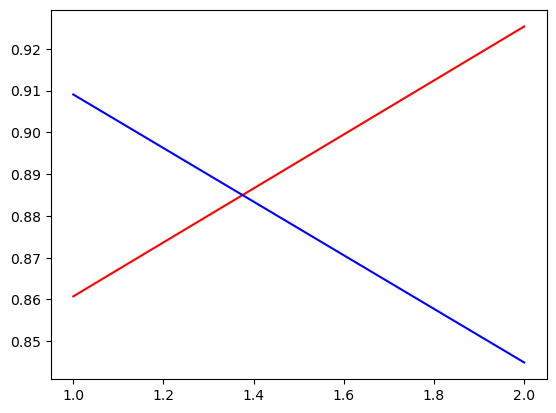

In [463]:
# Create a column transformer for encoding
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown='ignore'), ALL_FEATURES)
    ],
    remainder='passthrough')

train_dict = {}
test_dict = {}
for i in np.arange(1,3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i, stratify=y)
    y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)
    model_nb = CategoricalNB()
    pipeline_nb = settings.create_pipeline(["preprocess", column_trans], ["bernoulli_naive_bayes", model_nb])
    cv_nb = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=42)
    cv_scores = cross_val_score(pipeline_nb, X_train, y_train, scoring='accuracy', cv=cv_nb)
    train_dict[i] = cv_scores.mean()
    pipeline_nb.fit(X_train, y_train)
    test_accuracy = pipeline_nb.score(X_test, y_test)
    test_dict[i] = test_accuracy

plt.plot(np.arange(1,3), train_dict.values(), color="r")
plt.plot(np.arange(1,3), test_dict.values(), color="b")
plt.show()


In [360]:
# Save baseline pipeline to file  
settings.save_pipeline("best_naive_bayes_classification_pipeline.pkl", pipeline_nb)

*Hyperparam tuning*

*Smoothing*

In [ ]:
# set up param grid
param_grid_nb = {
    'multinomial_logistic_regression__penalty': ['l2', "none"] # l1 not typically used for multinomial due to compuataional and interpretibility challenges
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring='accuracy', cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

# Access best hyperparameters and accuracy score
best_params, best_train_score = grid_search_mlr.best_params_, grid_search_mlr.best_score_

# Print the best parameters
display("Best Parameters:", pd.DataFrame(best_params, index=[0]))

# Print the best mean cv training score
print("Mean CV Train Accuracy with best parameters:", settings.score_formatter(best_train_score, 4))

# Evaluate the best model on the test set
best_pipeline = grid_search_mlr.best_estimator_
test_accuracy = best_pipeline.score(X_test, y_test)
print("Test Accuracy with best parameters:", settings.score_formatter(test_accuracy, 4))

# Time to convergence 
print("Iterations to convergence:", best_model['multinomial_logistic_regression'].n_iter_[0])


'Best Parameters:'

,multinomial_logistic_regression__penalty
0,l2


Mean CV Train Accuracy with best parameters: 90.93 %
Test Accuracy with best parameters: 88.5 %
Iterations to convergence: 77
